###### 【問題1】自作データセットでの分類の学習
自作のデータセットに対して分類問題を解いてください。任意の実装を使用してください。

In [6]:
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import glob

Using TensorFlow backend.


In [3]:
folder = ["USAGI","AHIRU"]
image_size =  128
 
X = []
Y = []
filename = []
for index, name in enumerate(folder):
    dir = "./" + name
    files = glob.glob(dir + "/*.JPG")
    for i, file in enumerate(files):
        print(file)
        filename.append(str(file))
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        data = np.asarray(image)
        X.append(data)
        Y.append(index)
 
X = np.array(X)
Y = np.array(Y)

./USAGI/KIMG2621.JPG
./USAGI/KIMG2624.JPG
./AHIRU/KIMG2623.JPG
./AHIRU/KIMG2622.JPG
./AHIRU/KIMG2625.JPG


In [4]:
X = X.astype('float32')
X = X / 255.0

In [5]:
# 正解ラベルの形式を変換
Y = np_utils.to_categorical(Y, 2)

In [6]:
for i in range(len(Y)):
    print("Input={} Class={}".format(filename[i], np.argmax(Y[i])))

Input=./USAGI/KIMG2621.JPG Class=0
Input=./USAGI/KIMG2624.JPG Class=0
Input=./AHIRU/KIMG2623.JPG Class=1
Input=./AHIRU/KIMG2622.JPG Class=1
Input=./AHIRU/KIMG2625.JPG Class=1


USAGI = 0  
AHIRU = 1

In [7]:
X_train = X
y_train = Y

In [43]:
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0)

In [8]:
# CNNを構築
model = Sequential()

print(X_train.shape[1:])

model.add(Conv2D(32, (3, 3), padding='same',input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))
 
# コンパイル
model.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])

(128, 128, 3)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
history = model.fit(X_train, y_train, epochs=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
5/5 [==============================] - 1s 256ms/step - loss: 0.6512 - acc: 0.6000
Epoch 2/10
5/5 [==============================] - 0s 95ms/step - loss: 0.6456 - acc: 0.8000
Epoch 3/10
5/5 [==============================] - 0s 92ms/step - loss: 0.6832 - acc: 0.6000
Epoch 4/10
5/5 [==============================] - 0s 91ms/step - loss: 0.6994 - acc: 0.6000
Epoch 5/10
5/5 [==============================] - 0s 91ms/step - loss: 0.6878 - acc: 0.6000
Epoch 6/10
5/5 [==============================] - 0s 95ms/step - loss: 0.6541 - acc: 0.6000
Epoch 7/10
5/5 [==============================] - 0s 95ms/step - loss: 0.5845 - acc: 0.6000
Epoch 8/10
5/5 [==============================] - 0s 98ms/step - loss: 0.6259 - acc: 0.6000
Epoch 9/10
5/5 [==============================] - 0s 98ms/step - loss: 0.6557 - acc: 0.6000
Epoch 10/10
5/5 [==============================] - 0s 92ms/step - loss: 0.6996 - acc: 0.4000


###### TEST

In [10]:
folder = ["test"]
image_size = 128
 
X_test = []
for index, name in enumerate(folder):
    dir = "./" + name
    files = glob.glob(dir + "/*.JPG")
    for i, file in enumerate(files):
        print(file)
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        data = np.asarray(image)
        X_test.append(data)
        #Y.append(index)
 
X_test = np.array(X_test)
#Y = np.array(Y)

./test/KIMG2626.JPG


In [11]:
X_test = X_test.astype('float32')
X_test = X_test / 255.0

In [12]:
pred = model.predict(X_test)
print("Result=",pred)
print("Predicted class=[{}]".format(np.argmax(pred)))

Result= [[0.40354186 0.59645814]]
Predicted class=[1]


<img src="test/KIMG2626.JPG">

結果、上のイメージはアヒルと認識された。（答えはうさぎらしい。。。）

###### pipeline

In [13]:
from sklearn.metrics import accuracy_score

###### 【問題2】分類データセットに対するデータ拡張
データ拡張（Data Augmentation）を行ってください。

In [14]:
%matplotlib inline

In [15]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.color import label2rgb

import albumentations as A
import random

BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2, **kwargs):
    #height, width = img.shape[:2]

    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    return img

def visualize_titles(img, bbox, title, color=BOX_COLOR, thickness=2, font_thickness = 2, font_scale=0.35, **kwargs):
    #height, width = img.shape[:2]
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    
    ((text_width, text_height), _) = cv2.getTextSize(title, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, title, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, font_scale, TEXT_COLOR,
                font_thickness, lineType=cv2.LINE_AA)
    return img


def augment_and_show(aug, image, mask=None, bboxes=[], categories=[], category_id_to_name=[], filename=None, 
                     font_scale_orig=0.35, 
                     font_scale_aug=0.35, show_title=True, **kwargs):

    augmented = aug(image=image, mask=mask, bboxes=bboxes, category_id=categories)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_aug = cv2.cvtColor(augmented['image'], cv2.COLOR_BGR2RGB)

    for bbox in bboxes:
        visualize_bbox(image, bbox, **kwargs)

    for bbox in augmented['bboxes']:
        visualize_bbox(image_aug, bbox, **kwargs)

    if show_title:
        for bbox,cat_id in zip(bboxes, categories):
            visualize_titles(image, bbox, category_id_to_name[cat_id], font_scale=font_scale_orig, **kwargs)
        for bbox,cat_id in zip(augmented['bboxes'], augmented['category_id']):
            visualize_titles(image_aug, bbox, category_id_to_name[cat_id], font_scale=font_scale_aug, **kwargs)

    
    if mask is None:
        f, ax = plt.subplots(1, 2, figsize=(16, 8))
        
        ax[0].imshow(image)
        ax[0].set_title('Original image')
        
        ax[1].imshow(image_aug)
        ax[1].set_title('Augmented image')
    else:
        f, ax = plt.subplots(2, 2, figsize=(16, 16))
        
        if len(mask.shape) != 3:
            mask = label2rgb(mask, bg_label=0)            
            mask_aug = label2rgb(augmented['mask'], bg_label=0)
        else:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask_aug = cv2.cvtColor(augmented['mask'], cv2.COLOR_BGR2RGB)
            
        ax[0, 0].imshow(image)
        ax[0, 0].set_title('Original image')
        
        ax[0, 1].imshow(image_aug)
        ax[0, 1].set_title('Augmented image')
        
        ax[1, 0].imshow(mask, interpolation='nearest')
        ax[1, 0].set_title('Original mask')

        ax[1, 1].imshow(mask_aug, interpolation='nearest')
        ax[1, 1].set_title('Augmented mask')

    f.tight_layout()
    if filename is not None:
        f.savefig(filename)
        
    return augmented['image'], augmented['mask'], augmented['bboxes']

def find_in_dir(dirname):
    return [os.path.join(dirname, fname) for fname in sorted(os.listdir(dirname))]

In [16]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose
)

##### Color

In [17]:
random.seed(42)
image = cv2.imread('./USAGI/KIMG2621.JPG')

light = A.Compose([
    A.RandomBrightnessContrast(p=1),    
    A.RandomGamma(p=1),    
    A.CLAHE(p=1),    
], p=1)

medium = A.Compose([
    A.CLAHE(p=1),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=50, val_shift_limit=50, p=1),
], p=1)


strong = A.Compose([
    A.ChannelShuffle(p=1),
], p=1)

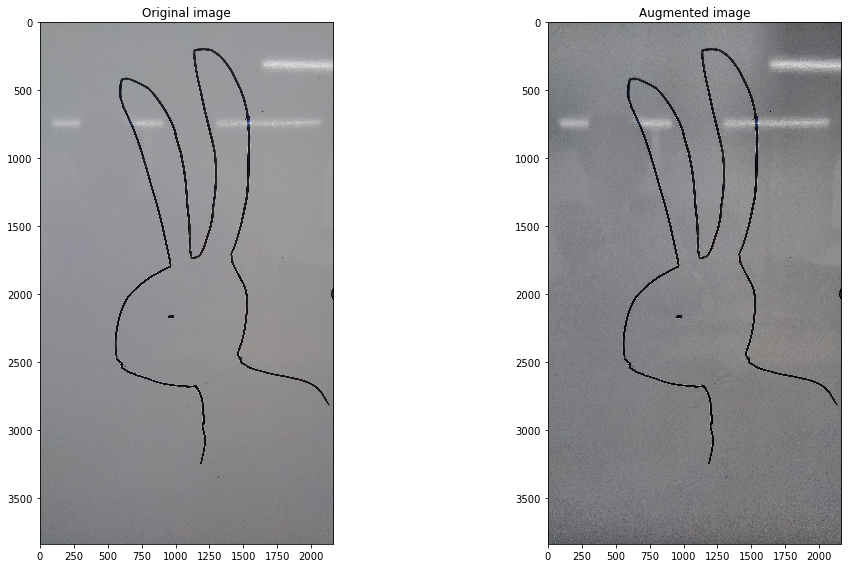

In [18]:
r = augment_and_show(light, image)

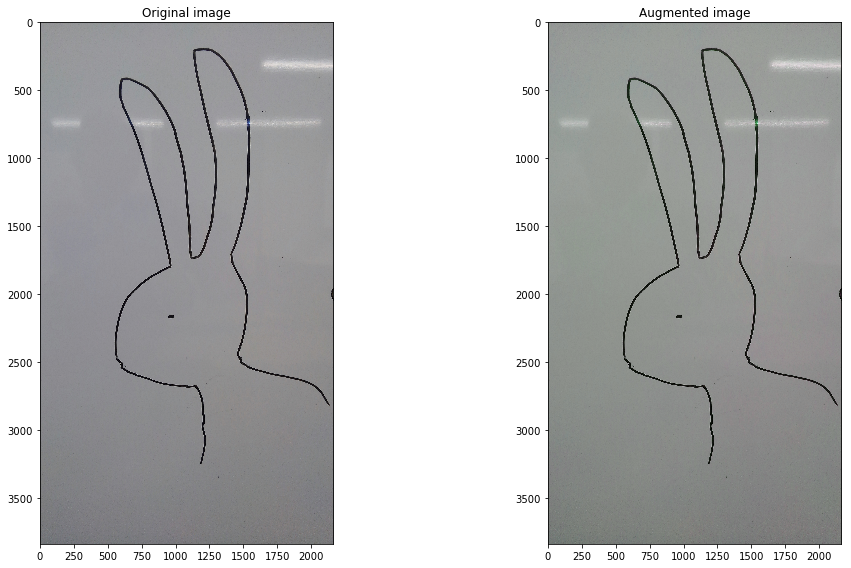

In [19]:
r = augment_and_show(strong, image)

##### 取りあえず回す

In [20]:
image = cv2.imread('./USAGI/KIMG2621.JPG')

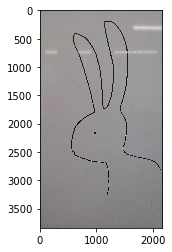

In [21]:
plt.imshow(np.array(image))

In [22]:
aug = Compose(
    [HorizontalFlip(0.2),
     ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=90, p=.5),
     OneOf([RandomContrast(), RandomBrightness(),], p=0.3)], 
    p=0.8) 

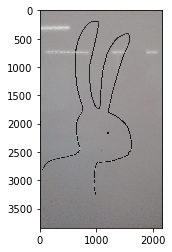

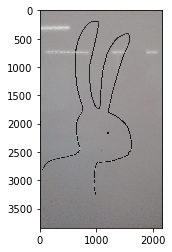

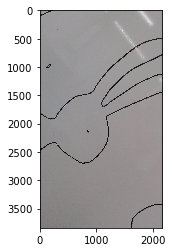

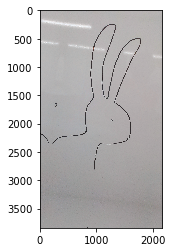

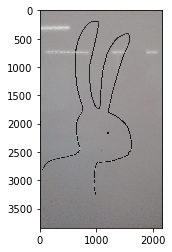

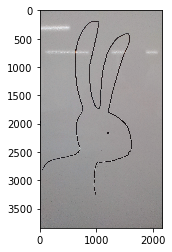

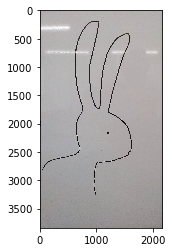

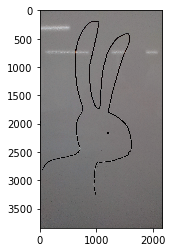

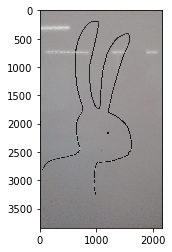

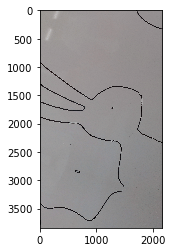

In [23]:
for _ in range(10):
    auged_img= aug(image=image)["image"]
    plt.imshow(np.array(auged_img))
    plt.show()

###### 関数

In [24]:
IMAGE_SIZE = 256
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [25]:
def create_model(data_shape):
    # CNNを構築
    print("data_size=", data_shape)
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=data_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])
    
    return model

In [42]:
def run_training(model, augmentation, n_epoch=10, n_aug=20, image_size = 128):
    folder = ["USAGI","AHIRU"]

    X = []
    Y = []
    filename = []
    for index, name in enumerate(folder):
        dir = "./" + name
        files = glob.glob(dir + "/*.JPG")
        for i, file in enumerate(files):
            #print(file)
            filename.append(str(file))
            image = Image.open(file)
            image = image.convert("RGB")
            image = image.resize((image_size, image_size))
            data = np.asarray(image)

            #Augmentation 
            for _ in range(n_aug):
                data = augmentation(image=data)["image"]
                X.append(data)
                Y.append(index)

    X = np.array(X)
    Y = np.array(Y)
    X = X.astype('float32')
    X = X / 255.0 #RGB正規化

    # 正解ラベルの形式を変換
    Y = np_utils.to_categorical(Y, 2)

    #sprit
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    
    history = model.fit(X_train, y_train, epochs=n_epoch, validation_split=0.2)
    #print("", model.evaluate(X_test, y_test))
    pred = model.predict(X_test)
    #print(pred)
    pred_class = np.argmax(pred, axis=1)
    ans_class = np.argmax(y_test, axis=1)
    print("Predicted class=[{}]".format(pred_class))
    print("Answer class=[{}]".format(ans_class))
    
    print("accuracy=",accuracy_score(pred_class, ans_class))

###### 何もしない（同じデータを複製）

In [27]:
aug = Compose(
    [HorizontalFlip(0.0)],
    p=0.0) 

In [251]:
run_training(create_model(data_shape = INPUT_SHAPE), aug, n_epoch=20, n_aug=20, image_size = IMAGE_SIZE)

data_size= (256, 256, 3)
Train on 64 samples, validate on 16 samples
Epoch 1/20
64/64 [==============================] - 32s 498ms/step - loss: 0.7904 - acc: 0.5312 - val_loss: 0.7023 - val_acc: 0.250
Epoch 2/20
64/64 [==============================] - 18s 288ms/step - loss: 0.6734 - acc: 0.6094 - val_loss: 0.6259 - val_acc: 0.750
Epoch 3/20
64/64 [==============================] - 18s 275ms/step - loss: 0.6575 - acc: 0.6406 - val_loss: 0.6190 - val_acc: 0.750
Epoch 4/20
64/64 [==============================] - 18s 274ms/step - loss: 0.6516 - acc: 0.6406 - val_loss: 0.6032 - val_acc: 0.750
Epoch 5/20
64/64 [==============================] - 18s 274ms/step - loss: 0.6517 - acc: 0.6406 - val_loss: 0.6083 - val_acc: 0.750
Epoch 6/20
64/64 [==============================] - 18s 286ms/step - loss: 0.6539 - acc: 0.6406 - val_loss: 0.6210 - val_acc: 0.750
Epoch 7/20
64/64 [==============================] - 18s 276ms/step - loss: 0.6526 - acc: 0.6406 - val_loss: 0.6013 - val_acc: 0.750
Epoch 8

###### フリップのみでやってみる

In [241]:
aug = Compose(
    [Flip(0.5)],
    p=0.5) 

In [242]:
run_training(create_model(data_shape = INPUT_SHAPE), aug, n_epoch=20, n_aug=20, image_size = IMAGE_SIZE)

data_size= (256, 256, 3)
Train on 64 samples, validate on 16 samples
Epoch 1/20
64/64 [==============================] - 32s 497ms/step - loss: 0.8384 - acc: 0.5781 - val_loss: 0.7115 - val_acc: 0.437
Epoch 2/20
64/64 [==============================] - 20s 320ms/step - loss: 0.7094 - acc: 0.5156 - val_loss: 0.6884 - val_acc: 0.562
Epoch 3/20
64/64 [==============================] - 18s 278ms/step - loss: 0.6839 - acc: 0.6250 - val_loss: 0.6874 - val_acc: 0.562
Epoch 4/20
64/64 [==============================] - 17s 272ms/step - loss: 0.6853 - acc: 0.6250 - val_loss: 0.6869 - val_acc: 0.562
Epoch 5/20
64/64 [==============================] - 19s 290ms/step - loss: 0.6452 - acc: 0.6250 - val_loss: 0.6859 - val_acc: 0.562
Epoch 6/20
64/64 [==============================] - 20s 306ms/step - loss: 0.6763 - acc: 0.6250 - val_loss: 0.6850 - val_acc: 0.562
Epoch 7/20
64/64 [==============================] - 17s 268ms/step - loss: 0.6558 - acc: 0.6250 - val_loss: 0.6843 - val_acc: 0.562
Epoch 8

###### 回転のみでやってみる

In [243]:
aug = Compose(
    [ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=.5)],
    p=0.5) 

In [244]:
run_training(create_model(data_shape = INPUT_SHAPE), aug, n_epoch=20, n_aug=20, image_size = IMAGE_SIZE)

data_size= (256, 256, 3)
Train on 64 samples, validate on 16 samples
Epoch 1/20
64/64 [==============================] - 31s 487ms/step - loss: 0.7457 - acc: 0.5469 - val_loss: 0.9911 - val_acc: 0.312
Epoch 2/20
64/64 [==============================] - 22s 342ms/step - loss: 0.9252 - acc: 0.4688 - val_loss: 0.6582 - val_acc: 0.687
Epoch 3/20
64/64 [==============================] - 20s 308ms/step - loss: 0.6742 - acc: 0.5938 - val_loss: 0.6639 - val_acc: 0.687
Epoch 4/20
64/64 [==============================] - 20s 308ms/step - loss: 0.6877 - acc: 0.6094 - val_loss: 0.6656 - val_acc: 0.687
Epoch 5/20
64/64 [==============================] - 19s 290ms/step - loss: 0.6720 - acc: 0.6250 - val_loss: 0.6686 - val_acc: 0.687
Epoch 6/20
64/64 [==============================] - 19s 304ms/step - loss: 0.6819 - acc: 0.5781 - val_loss: 0.6655 - val_acc: 0.687
Epoch 7/20
64/64 [==============================] - 19s 302ms/step - loss: 0.6695 - acc: 0.6094 - val_loss: 0.6573 - val_acc: 0.687
Epoch 8

##### フリップ +  回転 

In [246]:
aug = Compose(
    [ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=.5)],
    [Flip(0.5)],
    p=0.5) 

In [247]:
run_training(create_model(data_shape = INPUT_SHAPE), aug, n_epoch=20, n_aug=20, image_size = IMAGE_SIZE)

data_size= (256, 256, 3)
Train on 64 samples, validate on 16 samples
Epoch 1/20
64/64 [==============================] - 34s 534ms/step - loss: 0.6093 - acc: 0.6719 - val_loss: 0.7004 - val_acc: 0.500
Epoch 2/20
64/64 [==============================] - 22s 338ms/step - loss: 0.9241 - acc: 0.6406 - val_loss: 0.7015 - val_acc: 0.500
Epoch 3/20
64/64 [==============================] - 21s 333ms/step - loss: 0.8002 - acc: 0.3906 - val_loss: 0.6999 - val_acc: 0.500
Epoch 4/20
64/64 [==============================] - 23s 355ms/step - loss: 0.6424 - acc: 0.6719 - val_loss: 0.7078 - val_acc: 0.500
Epoch 5/20
64/64 [==============================] - 23s 357ms/step - loss: 0.6213 - acc: 0.6719 - val_loss: 0.7135 - val_acc: 0.500
Epoch 6/20
64/64 [==============================] - 21s 326ms/step - loss: 0.6307 - acc: 0.6719 - val_loss: 0.7132 - val_acc: 0.500
Epoch 7/20
64/64 [==============================] - 21s 330ms/step - loss: 0.6110 - acc: 0.6719 - val_loss: 0.7121 - val_acc: 0.500
Epoch 8

###### SCALE (Random, shift, rotationはしない)

In [248]:
aug = Compose(
    [ShiftScaleRotate(shift_limit=0.0, scale_limit=0.5, rotate_limit=0, p=.5)],
    [Flip(0.5)],
    p=0.5) 

In [249]:
run_training(create_model(data_shape = INPUT_SHAPE), aug, n_epoch=20, n_aug=20, image_size = IMAGE_SIZE)

data_size= (256, 256, 3)
Train on 64 samples, validate on 16 samples
Epoch 1/20
64/64 [==============================] - 28s 445ms/step - loss: 1.0546 - acc: 0.5625 - val_loss: 0.9282 - val_acc: 0.312
Epoch 2/20
64/64 [==============================] - 19s 294ms/step - loss: 0.9676 - acc: 0.4062 - val_loss: 0.6887 - val_acc: 0.687
Epoch 3/20
64/64 [==============================] - 19s 291ms/step - loss: 0.6949 - acc: 0.4688 - val_loss: 0.6798 - val_acc: 0.687
Epoch 4/20
64/64 [==============================] - 17s 265ms/step - loss: 0.6867 - acc: 0.6094 - val_loss: 0.6758 - val_acc: 0.687
Epoch 5/20
64/64 [==============================] - 17s 268ms/step - loss: 0.6893 - acc: 0.5938 - val_loss: 0.6726 - val_acc: 0.687
Epoch 6/20
64/64 [==============================] - 17s 258ms/step - loss: 0.6702 - acc: 0.6094 - val_loss: 0.6670 - val_acc: 0.687
Epoch 7/20
64/64 [==============================] - 18s 279ms/step - loss: 0.6984 - acc: 0.5938 - val_loss: 0.6687 - val_acc: 0.687
Epoch 8

###### augmentationの枚数を増やす

In [28]:
aug = Compose(
    [ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=.5)],
    [Flip(0.5)],
    p=0.5) 

In [29]:
model = create_model(data_shape = INPUT_SHAPE)

data_size= (256, 256, 3)


In [30]:
run_training(model, aug, n_epoch=20, n_aug=50, image_size = IMAGE_SIZE)

Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 58s 365ms/step - loss: 0.7193 - acc: 0.5875 - val_loss: 0.6783 - val_acc: 0.600
Epoch 2/20
160/160 [==============================] - 42s 264ms/step - loss: 0.6988 - acc: 0.5750 - val_loss: 0.6747 - val_acc: 0.60
Epoch 3/20
160/160 [==============================] - 42s 264ms/step - loss: 0.6957 - acc: 0.5875 - val_loss: 0.6794 - val_acc: 0.60
Epoch 4/20
160/160 [==============================] - 42s 260ms/step - loss: 0.6886 - acc: 0.5938 - val_loss: 0.6871 - val_acc: 0.60
Epoch 5/20
160/160 [==============================] - 41s 257ms/step - loss: 0.6796 - acc: 0.5812 - val_loss: 0.6837 - val_acc: 0.60
Epoch 6/20
160/160 [==============================] - 42s 265ms/step - loss: 0.6830 - acc: 0.5938 - val_loss: 0.6810 - val_acc: 0.60
Epoch 7/20
160/160 [==============================] - 42s 263ms/step - loss: 0.6850 - acc: 0.6063 - val_loss: 0.6808 - val_acc: 0.60
Epoch 8/20
160/160 [===

In [31]:
#スマホで撮ったデータが逆さまなため反転させる
aug = Compose(
    [ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=180, p=1)],
    p=1) 

./test2/KIMG2632.JPG


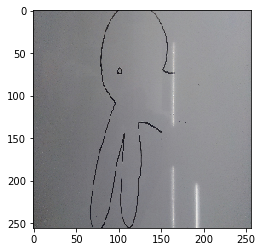

./test2/KIMG2627.JPG


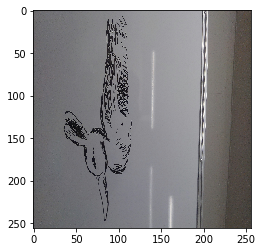

./test2/KIMG2630.JPG


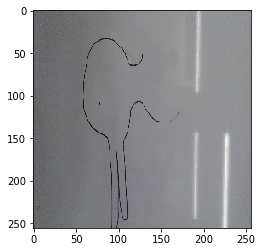

./test2/KIMG2629.JPG


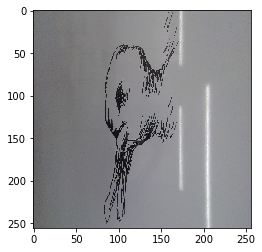

./test2/KIMG2628.JPG


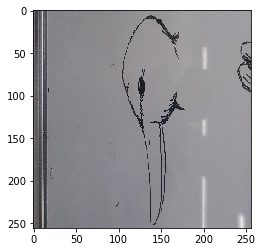

In [38]:
folder = ["test2"]

X_test = []
for index, name in enumerate(folder):
    dir = "./" + name
    files = glob.glob(dir + "/*.JPG")
    for i, file in enumerate(files):
        print(file)
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
        #イメージの反転
        plt.imshow(np.array(image))
        plt.show()
        
        data = np.asarray(image)
        data = aug(image=data)['image']
        X_test.append(data)
        #Y.append(index)
 
X_test = np.array(X_test)

In [41]:
#RGB正規化
X_test = X_test.astype('float32')
X_test = X_test / 255.0

In [40]:
pred = model.predict(X_test)
print("Result=",pred)
print("Predicted class=[{}]".format(np.argmax(pred, axis=1)))

Result= [[0.47074902 0.529251  ]
 [0.4722299  0.5277701 ]
 [0.47261438 0.5273856 ]
 [0.46992537 0.5300746 ]
 [0.4690238  0.53097624]]
Predicted class=[[1 1 1 1 1]]


USAGI = 0  
AHIRU = 1  

結果、全てアヒルとなった。しかし各ラベルの確率を見るとその差は僅差だった。

###### 【問題4】物体検出データセットの用意
次に、物体検出を行います。バウンディングボックスのアノテーションを行い物体検出のためのデータセットを作成してください。

In [96]:
folder_name = "rabbit_duck"
folder = [folder_name]

new_file = open("./rabbit_duck/train.txt", "w")
annotation_data = []
for index, name in enumerate(folder):
    dir = "./" + name
    files = glob.glob(dir + "/*.txt")
    img_files = glob.glob(dir + "/*.JPG")
    for i, file in enumerate(files):
        image = Image.open(img_files[i])
        tmp = np.asarray(image)
        x_size = tmp.shape[0]
        y_size = tmp.shape[1]
        
        f = open(file)
        text = f.read()
        lines = text.split('\n')
        print(file)
        file = file.replace(".txt", ".JPG")
        for line in lines:
            all_data = line.split()
            if len(all_data) > 2:
                x1 = (float)(all_data[1]) * x_size
                y1 = (float)(all_data[2]) * y_size 
                x2 = (float)(all_data[3]) * x_size 
                y2 = (float)(all_data[4]) * y_size
                
                x_min = x2
                y_min = y2 - 2 * (y2 - y1)
                x_max = x2 + 2 * (x1 - x2)
                y_max = y2
                tmp = "{} {},{},{},{},{}\n".format(file, 
                                                   (int)(x_max), 
                                                   (int)(y_max), 
                                                   (int)(x_min), 
                                                   (int)(y_min), 
                                                   all_data[0])
                new_file.write(tmp)

f.close()
new_file.close()
#X_test = np.array(X_test)

./rabbit_duck/duck_rabbit1.txt
./rabbit_duck/duck_rabbit3.txt
./rabbit_duck/duck_rabbit2.txt
./rabbit_duck/duck5.txt
./rabbit_duck/duck4.txt
./rabbit_duck/train.txt
./rabbit_duck/duck6.txt
./rabbit_duck/duck7.txt
./rabbit_duck/duck3.txt
./rabbit_duck/duck2.txt
./rabbit_duck/duck1.txt
./rabbit_duck/rabbit2.txt
./rabbit_duck/rabbit3.txt
./rabbit_duck/rabbit1.txt


IndexError: list index out of range

In [42]:
import xml.etree.ElementTree as ET

folder_name = "rabbit_duck"
folder = [folder_name]
new_file = open("./rabbit_duck/train.txt", "w")
    
for index, name in enumerate(folder):
    dir = "./" + name
    files = glob.glob(dir + "/*.xml")
    for i, file in enumerate(files):
        print(file)
        
        class_name = []
        x_min = []
        x_max = []
        y_min = []
        y_max = []
        tree = ET.parse(file)
        root = tree.getroot()

        for path in root.iter('path'):
            filepath = path.text
        
        for name in root.iter('name'):
            class_name.append(name.text)
        
        for xmin in root.iter('xmin'):
            x_min.append(xmin.text)
            
        for ymin in root.iter('ymin'):
            y_min.append(ymin.text)
            
        for xmax in root.iter('xmax'):
            x_max.append(xmax.text)
            
        for ymax in root.iter('ymax'):
            y_max.append(ymax.text)
        
        for i in range(len(class_name)):
            tmp = "{} {},{},{},{},{}\n".format(filepath, x_min[i], y_min[i], x_max[i], y_max[i], class_name[i])
            tmp = tmp.replace(",duck", ",0")
            tmp = tmp.replace(",rabbit", ",1")
            new_file.write(tmp)
            
new_file.close()

./rabbit_duck/duck4.xml
./rabbit_duck/duck5.xml
./rabbit_duck/duck7.xml
./rabbit_duck/duck6.xml
./rabbit_duck/duck2.xml
./rabbit_duck/duck3.xml
./rabbit_duck/duck1.xml
./rabbit_duck/duck_rabbit1.xml
./rabbit_duck/duck_rabbit2.xml
./rabbit_duck/duck_rabbit3.xml
./rabbit_duck/rabbit3.xml
./rabbit_duck/rabbit2.xml
./rabbit_duck/duck8.xml
./rabbit_duck/rabbit1.xml


###### 【問題5】物体検出データセットに対するデータ拡張
データ拡張（Data Augmentation）を行ってください。前述のalbumentationsはバウンディングボックスを合わせての加工が可能です。詳細はREADME.mdを確認してください。

In [43]:
aug = Compose(
    [HorizontalFlip(0.0)],
    p=0.0) 

./AHIRU_USAGI/KIMG2634.JPG


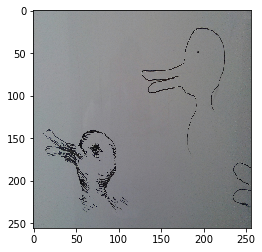

./AHIRU_USAGI/KIMG2635.JPG


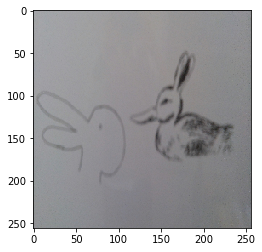

./AHIRU_USAGI/KIMG2636.JPG


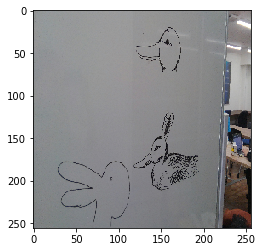

In [58]:
folder = ["AHIRU_USAGI"]

X_test = []
for index, name in enumerate(folder):
    dir = "./" + name
    files = glob.glob(dir + "/*.JPG")
    for i, file in enumerate(files):
        print(file)
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
        #イメージの反転
        plt.imshow(np.array(image))
        plt.show()
        data = np.asarray(image)
        for n in range(2):
            data = aug(image=data)['image']
            #data = data.astype('float32')
            #data = data / 255.0 #RGB正規化
            #img = Image.fromarray(data)
            filename= "test_aug_{}_{}.JPG".format(i, n)
            cv2.imwrite(filename, data)
            #X_test.append(data)
            #Y.append(index)
 
#X_test = np.array(X_test)

バウンディングボックスがうまくいかなかったのでサイトの情報を参考にする

In [1]:
from urllib.request import urlopen
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Resize,
    CenterCrop,
    RandomCrop,
    Crop,
    Compose
)

In [2]:
def download_image(url):
    data = urlopen(url).read()
    data = np.frombuffer(data, np.uint8)
    image = cv2.imdecode(data, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [3]:
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)

In [4]:
def get_aug(aug, min_area=0., min_visibility=0.):
    return Compose(aug, bbox_params={'format': 'coco', 'min_area': min_area, 'min_visibility': min_visibility, 'label_fields': ['category_id']})

In [5]:
image = download_image('http://images.cocodataset.org/train2017/000000386298.jpg')

In [7]:
# Annotations for image 386298 from COCO http://cocodataset.org/#explore?id=386298
annotations = {'image': image, 'bboxes': [[366.7, 80.84, 132.8, 181.84], [5.66, 138.95, 147.09, 164.88]], 'category_id': [18, 17]}
category_id_to_name = {17: 'cat', 18: 'dog'}

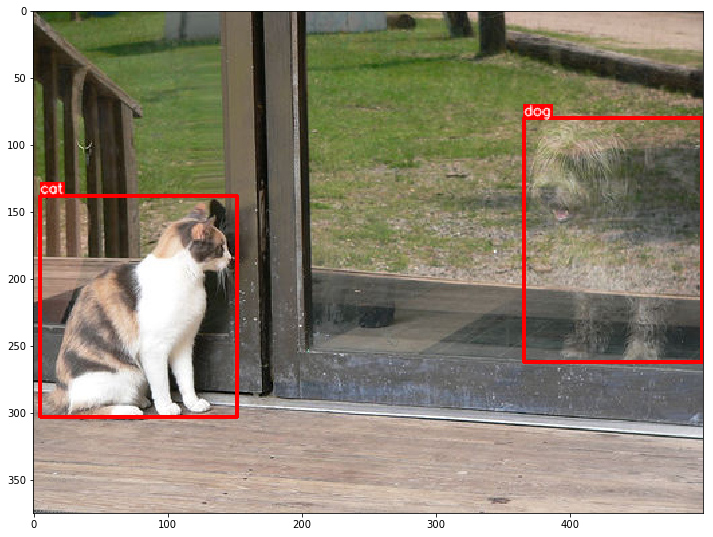

In [8]:
visualize(annotations, category_id_to_name)

回転

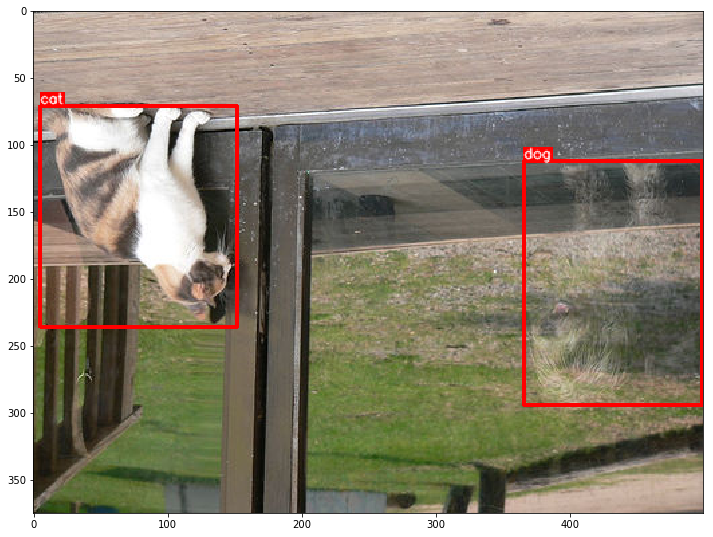

In [9]:
aug = get_aug([VerticalFlip(p=1)])
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)

左右反転

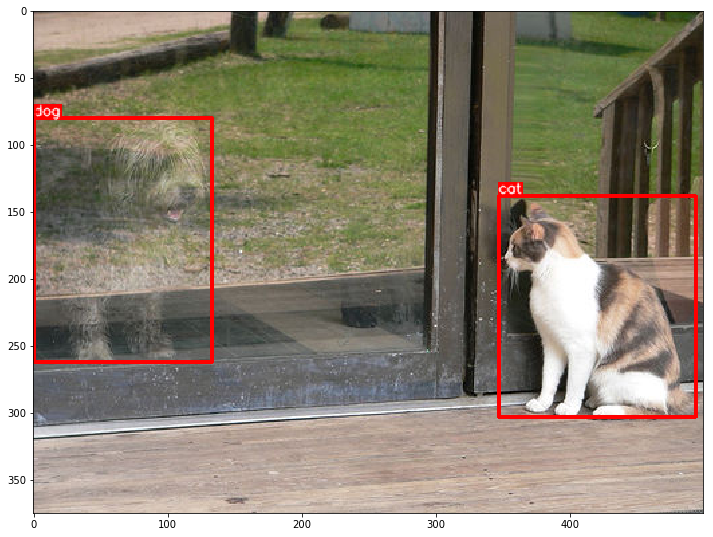

In [10]:
aug = get_aug([HorizontalFlip(p=1)])
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)